# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

In this project, we need to understand what are the main factors that determine the price of a used car. 

To this purpose, we will use a dataset containing different characteritics of several used cars. The more the data, the more material we have to analyse. 

From this dataset, we will determine which features are important for a used car dealer.

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [937]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import stats
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn import set_config
set_config(display="diagram")
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [938]:
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel

In [939]:
df = pd.read_csv('data/vehicles.csv')

We firstly have a look in the data as a whole. We identify the number and names of columns, the number of rows, the number of null, nan values, data type.

In [940]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [941]:
df_nan = df.isna().sum()
df_nan

id                   0
region               0
price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
VIN             161042
drive           130567
size            306361
type             92858
paint_color     130203
state                0
dtype: int64

In [942]:
df.shape

(426880, 18)

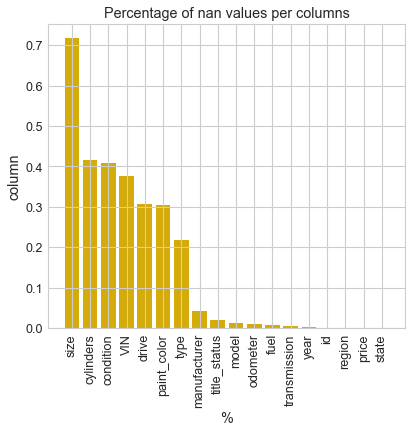

In [943]:
plt.bar(x=df_nan.sort_values(ascending=False).index, 
        height=df_nan.sort_values(ascending=False)/df.shape[0],
        color='#d5ab09'
       )
plt.xticks(rotation=90)
plt.xlabel('%')
plt.ylabel('column')
plt.title('Percentage of nan values per columns');


We observe that the columns containing the highest proportion of nan values are:
- Size
- Cylinders
- Condition
- VIN
- Drive
- Paint color
- Type

These columns have nan values for more than 20% of the total number of rows. We cannot just drop the rows containing nan values since we risk ending up with very few data. For example if we do:

In [944]:
df.dropna().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34868 entries, 126 to 426836
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            34868 non-null  int64  
 1   region        34868 non-null  object 
 2   price         34868 non-null  int64  
 3   year          34868 non-null  float64
 4   manufacturer  34868 non-null  object 
 5   model         34868 non-null  object 
 6   condition     34868 non-null  object 
 7   cylinders     34868 non-null  object 
 8   fuel          34868 non-null  object 
 9   odometer      34868 non-null  float64
 10  title_status  34868 non-null  object 
 11  transmission  34868 non-null  object 
 12  VIN           34868 non-null  object 
 13  drive         34868 non-null  object 
 14  size          34868 non-null  object 
 15  type          34868 non-null  object 
 16  paint_color   34868 non-null  object 
 17  state         34868 non-null  object 
dtypes: float64(2), int64(2)

Then, we oberve that we end up with only 34868 rows out of 426K rows, which represents ony

In [945]:
(34868 /426880 )*100

8.168103448275863

**8.17%**. This can be a considerable loss of data. In order to know what we can do, we can explore the contents of the columns containing the most nan values and to explore possible workaround.

In [946]:
df_nan_analyse = df_nan.sort_values(ascending=False)[:7]
df_nan_analyse

size           306361
cylinders      177678
condition      174104
VIN            161042
drive          130567
paint_color    130203
type            92858
dtype: int64

We create a dictionary whose keys are the columns that contain NaN values. Besides, for each key, the value will be the different values in that column. 

This will help us to see whcih values can be used to replace missing ones.

In [947]:
dict_nan_unique = {}
for col in (df_nan_analyse.index):
    nan_val = df[col].unique()
    dict_nan_unique[col] = nan_val
    

In [948]:
dict_nan_unique

{'size': array([nan, 'full-size', 'mid-size', 'compact', 'sub-compact'],
       dtype=object),
 'cylinders': array([nan, '8 cylinders', '6 cylinders', '4 cylinders', '5 cylinders',
        'other', '3 cylinders', '10 cylinders', '12 cylinders'],
       dtype=object),
 'condition': array([nan, 'good', 'excellent', 'fair', 'like new', 'new', 'salvage'],
       dtype=object),
 'VIN': array([nan, '3GTP1VEC4EG551563', '1GCSCSE06AZ123805', ...,
        '2HGES15535H620534', '1FDWF37P64EA24868', 'SAJGX2749VCOO8376'],
       dtype=object),
 'drive': array([nan, 'rwd', '4wd', 'fwd'], dtype=object),
 'paint_color': array([nan, 'white', 'blue', 'red', 'black', 'silver', 'grey', 'brown',
        'yellow', 'orange', 'green', 'custom', 'purple'], dtype=object),
 'type': array([nan, 'pickup', 'truck', 'other', 'coupe', 'SUV', 'hatchback',
        'mini-van', 'sedan', 'offroad', 'bus', 'van', 'convertible',
        'wagon'], dtype=object)}

We can see that some characteristics are important like size, cylinders (which can determine gasoline consumption), condition, drive and type. But VIN (Vehicle Idnetification Number) is not revlevant at all. 

Since losing data in thiese columns would make us lose almost 20% of data in a column, we will fill the empty/nan values wit the most frequent but simialr one.

### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

#### Filling in missing values with most frequent/similar value

If we want to have a proper data cleaning, we need to fill in all missing values. Nevertheless, we need to take care of values that can be too different. For example, it is not the same a 4 cylinders than one with 12 cylinders.

We will take care of each columns for whcih more than its 20% values are missing. We need to do this because otherwise we might end up with very few daya.


We begin by noticing that some columns don't bring added value like VIN or ID. And so we drop them.



In [949]:
df.drop(columns=['VIN','id', 'state','region', 'state'], 
        inplace=True
       )

In [950]:
dict_nan_unique.pop('VIN')

array([nan, '3GTP1VEC4EG551563', '1GCSCSE06AZ123805', ...,
       '2HGES15535H620534', '1FDWF37P64EA24868', 'SAJGX2749VCOO8376'],
      dtype=object)

In [951]:
dict_nan_unique

{'size': array([nan, 'full-size', 'mid-size', 'compact', 'sub-compact'],
       dtype=object),
 'cylinders': array([nan, '8 cylinders', '6 cylinders', '4 cylinders', '5 cylinders',
        'other', '3 cylinders', '10 cylinders', '12 cylinders'],
       dtype=object),
 'condition': array([nan, 'good', 'excellent', 'fair', 'like new', 'new', 'salvage'],
       dtype=object),
 'drive': array([nan, 'rwd', '4wd', 'fwd'], dtype=object),
 'paint_color': array([nan, 'white', 'blue', 'red', 'black', 'silver', 'grey', 'brown',
        'yellow', 'orange', 'green', 'custom', 'purple'], dtype=object),
 'type': array([nan, 'pickup', 'truck', 'other', 'coupe', 'SUV', 'hatchback',
        'mini-van', 'sedan', 'offroad', 'bus', 'van', 'convertible',
        'wagon'], dtype=object)}

Now we create a dictionary that shows, for every column containing NaN, the count for every distinct value. This will help us to know which value is the most frequent one.

In [952]:
dict_count_uniques = {}
for col_u in dict_nan_unique.keys():
    
    dict_count_uniques[str(col_u)] = {}
    
    for i,uniq_val in enumerate(dict_nan_unique[col_u]):
        
        text_uniq_val = str(uniq_val)
        
        if  text_uniq_val=='nan':
        
            dict_count_uniques[col_u]['NaN'] = None
            count_unique = df[col_u].isna().sum()
            dict_count_uniques[col_u]['NaN'] = count_unique

        else:

            dict_count_uniques[col_u][uniq_val] = None
            count_unique = df[df[col_u]==uniq_val].shape[0]
            dict_count_uniques[col_u][uniq_val] = count_unique

In [953]:
# Example, We count, in the column 'size', how many appearance for evey unique value
dict_count_uniques['size']

{'NaN': 306361,
 'full-size': 63465,
 'mid-size': 34476,
 'compact': 19384,
 'sub-compact': 3194}

In [954]:
# Example, We count, in the column 'cylinders', how many appearance for evey unique value
dict_count_uniques['cylinders']

{'NaN': 177678,
 '8 cylinders': 72062,
 '6 cylinders': 94169,
 '4 cylinders': 77642,
 '5 cylinders': 1712,
 'other': 1298,
 '3 cylinders': 655,
 '10 cylinders': 1455,
 '12 cylinders': 209}

We plot this dictionary in order to know the proportion of NaN values with repsect to other non-NaN values

In [955]:
import warnings
warnings.filterwarnings("ignore")

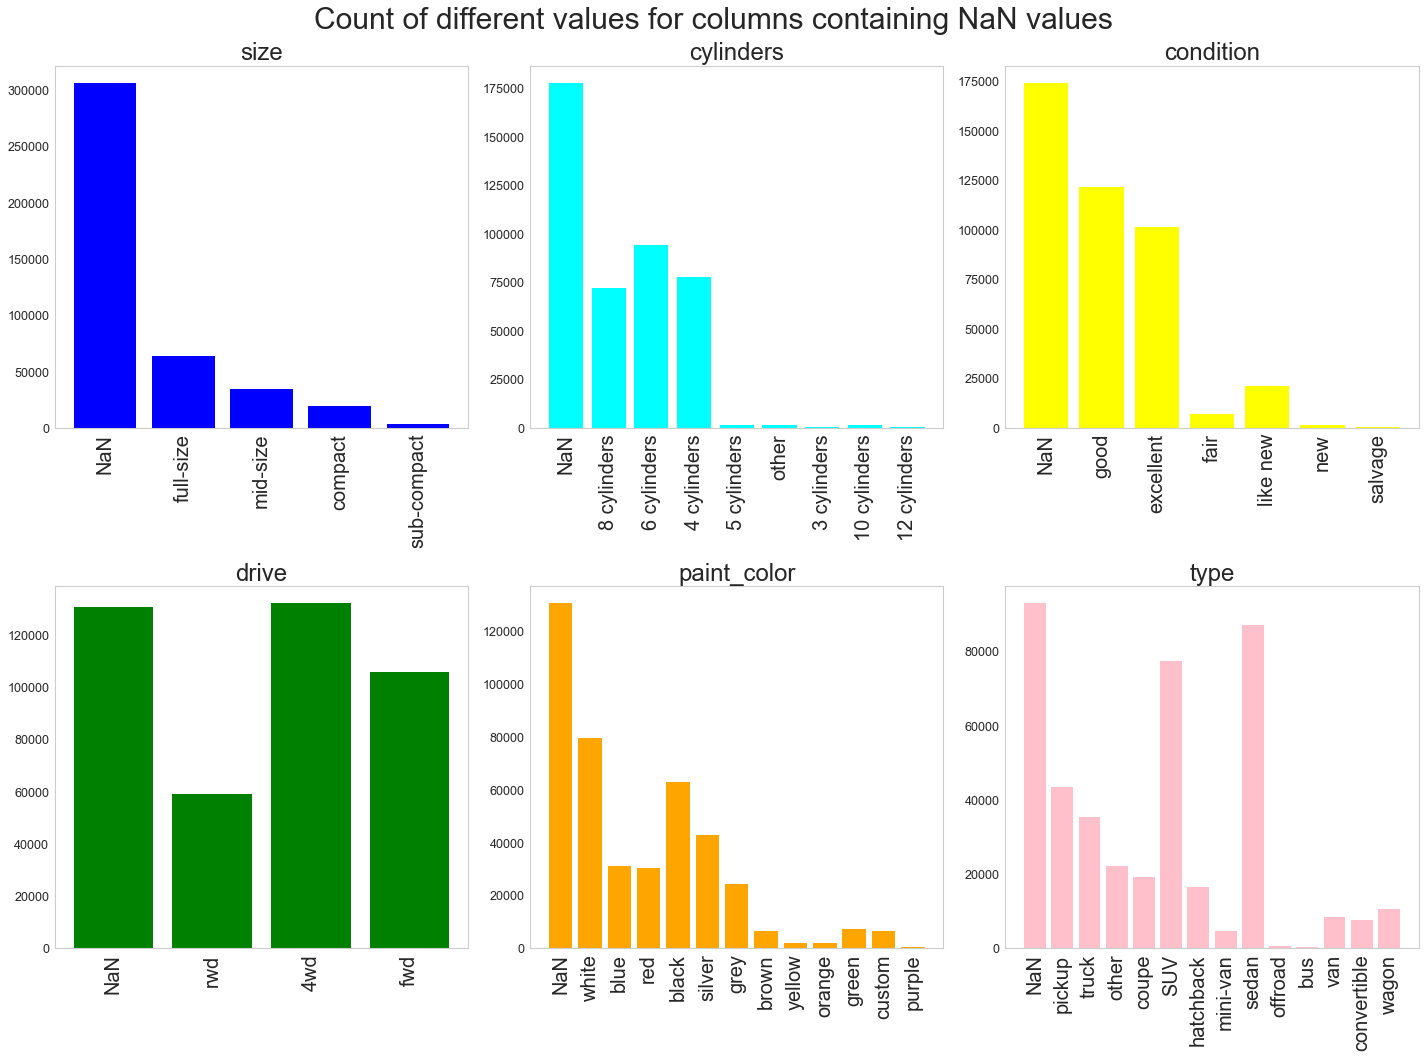

In [956]:
fig,axis =plt.subplots(2,3,figsize=(20,15))
colors=['blue','cyan','yellow','green','orange','pink']

count=0
for row  in np.arange(0,axis.shape[0]):
    for col in np.arange(0,axis.shape[1]):
        if (count<len(dict_count_uniques.keys())):
                        
            key_subplt = list(dict_count_uniques.keys())[count]
            
            x=list(dict_count_uniques[key_subplt].keys())
            height = list(dict_count_uniques[key_subplt].values())
            
            axis[row][col].bar(x=x,
                               height=height, 
                               color=colors[count]
                              )

            axis[row][col].set_xticklabels(x, rotation=90, size=20)
            axis[row][col].set_title(key_subplt, size=24)

            axis[row][col].grid(False)


            count += 1
        else:
           
            axis[row][col].axis('off')
            
fig.suptitle('Count of different values for columns containing NaN values',fontsize=30 )
fig.tight_layout()


In [957]:
df_cleaned = df.copy()

In [958]:
df_cleaned['size'].fillna('full-size', inplace=True)
df_cleaned['cylinders'].fillna('6 cylinders', inplace=True)
df_cleaned['condition'].fillna('good', inplace=True)
df_cleaned['drive'].fillna('4wd', inplace=True)
df_cleaned['paint_color'].fillna('white', inplace=True)
df_cleaned['type'].fillna('sedan', inplace=True)


We check the proportion of null/NaN values in our cleaned dataframe

In [959]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         426880 non-null  int64  
 1   year          425675 non-null  float64
 2   manufacturer  409234 non-null  object 
 3   model         421603 non-null  object 
 4   condition     426880 non-null  object 
 5   cylinders     426880 non-null  object 
 6   fuel          423867 non-null  object 
 7   odometer      422480 non-null  float64
 8   title_status  418638 non-null  object 
 9   transmission  424324 non-null  object 
 10  drive         426880 non-null  object 
 11  size          426880 non-null  object 
 12  type          426880 non-null  object 
 13  paint_color   426880 non-null  object 
dtypes: float64(2), int64(1), object(11)
memory usage: 45.6+ MB


In [960]:
df_cleaned.dropna(inplace=True)

We ended up with 91% of data from the original datset.

In [961]:
df_cleaned.shape[0]/df.shape[0]

0.912678035982009

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

We will analyze what seems to be the most relevant columns in the data set and we will confirm thanks to the mean squared error

Firstly, we will apply a StandardScaler to a column containing numerical values. In our case, it is the odometer. In a general case, more than one columsn can be standardized in a similar way.

In [962]:
scaler = StandardScaler()
df_cleaned['odometer'] = scaler.fit_transform(df_cleaned[['odometer']])


Now, we define the X and y datsets. Since we are interested in the price, so y will be the price column.

Then we divide our dataset in our train and test set

In [963]:
X = df_cleaned.drop(columns=['price'])
y = df_cleaned['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)



We will use 2 models:

- Linear Regression Model
- Ridge Model

## Linear Regression Model

There are different features in our dataset. Some are numerical, other are ordinal. We will limit the features that will be analysed so that we can focus in the principle, but this can be generalized to a greater extent. The features we chose are those for which we can expect to have agreta impact in the price.

In [964]:
polynom_ord_ohe = make_column_transformer((OneHotEncoder(drop = 'if_binary'), ['drive','size', 'cylinders'],
                                           ),
                                           (OrdinalEncoder(categories = [['good', 'excellent', 'fair', 'like new', 'new', 'salvage']]), 
                                            ['condition']
                                           ),
                                           (PolynomialFeatures(include_bias = False, degree = 3), ['odometer']
                                           ),
                                           remainder='passthrough'
                                          )

In [965]:
pipe_linreg = Pipeline([('transformer', polynom_ord_ohe), 
                        ('linreg', LinearRegression())
                       ]
                      )

In [966]:
pipe_linreg.fit(X_train[['drive','condition','odometer','size', 'cylinders']], 
                y_train
               )


Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['drive', 'size',
                                                   'cylinders']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['good',
                                                                              'excellent',
                                                                              'fair',
                                                                              'like '
                                                                              'new',
                                                                              'new',
                                                                              'salvage']]),
                                                  ['condition']),
                                                 ('polynomialfeatures',
                                                  PolynomialFeatures(degree=3,
                                                                     include_bias=False),
                                                  ['odometer'])])),
                ('linreg', LinearRegression())])

In [967]:
linreg_train_preds = pipe_linreg.predict(X_train[['drive','condition','odometer','size', 'cylinders']])
linreg_test_preds  = pipe_linreg.predict(X_test[['drive','condition','odometer','size', 'cylinders']])

linreg_mse_train = mean_squared_error(y_train, linreg_train_preds)
linreg_mse_test = mean_squared_error(y_test, linreg_test_preds)

This model shows an error of :

In [968]:
print('Mean Squared Error for train set of linear regression=', linreg_mse_train)
print('Mean Squared Error for test set of linear regression=', linreg_mse_test)

Mean Squared Error for train set of linear regression= 72839994466161.97
Mean Squared Error for test set of linear regression= 266941162206023.75


We notice that the test mean square error is bigger than the one for the train set.

In [969]:
pipe_linreg.named_steps['linreg'].coef_

array([ 2.59989969e+04, -1.86656375e+04, -7.33335939e+03, -3.82094821e+03,
        1.68593877e+04, -7.27589968e+03, -5.76253979e+03, -1.53039544e+04,
        1.81446608e+04,  9.57781294e+02, -3.29944899e+03, -9.18716112e+03,
        2.82100578e+04, -1.57339034e+04, -3.78803194e+03,  2.73548318e+03,
        1.48201970e+04, -1.27218283e+03,  1.89683498e+01])

## Ridge Model

The second model will be a Ridge Model for which we verify which alpha is the best to chose thanks to a GridSearchCV.

In [970]:

pipe_ridge = Pipeline([('transformer', polynom_ord_ohe), 
                        ('ridge', Ridge())
                      ]
                     )

param_dict_ridge =  {'ridge__alpha': [0.1,10,50,100,500,1000]}


grid_ridge = GridSearchCV(estimator=pipe_ridge, 
                          param_grid=param_dict_ridge,
                          cv=5
                          )


grid_ridge.fit(X_train[['drive','condition','odometer','size', 'cylinders']], y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='if_binary'),
                                                                         ['drive',
                                                                          'size',
                                                                          'cylinders']),
                                                                        ('ordinalencoder',
                                                                         OrdinalEncoder(categories=[['good',
                                                                                                     'excellent',
                                                                                                     'fair',
                                                                                                     'like '
                                                                                                     'new',
                                                                                                     'new',
                                                                                                     'salvage']]),
                                                                         ['condition']),
                                                                        ('polynomialfeatures',
                                                                         PolynomialFeatures(degree=3,
                                                                                            include_bias=False),
                                                                         ['odometer'])])),
                                       ('ridge', Ridge())]),
             param_grid={'ridge__alpha': [0.1, 10, 50, 100, 500, 1000]})

In [971]:
ridge_train_preds = grid_ridge.best_estimator_.predict(X_train[['drive','condition','odometer','size', 'cylinders']])
ridge_test_preds  = grid_ridge.best_estimator_.predict(X_test[['drive','condition','odometer','size', 'cylinders']])

ridge_mse_train = mean_squared_error(y_train, ridge_train_preds)
ridge_mse_test = mean_squared_error(y_test, ridge_test_preds)

In [972]:
print('Mean Squared Error for train set of Ridge Model=',ridge_mse_train)
print('Mean Squared Error for test set of Ridge Model=',ridge_mse_test)

Mean Squared Error for train set of Ridge Model= 72839994975651.73
Mean Squared Error for test set of Ridge Model= 266941162611494.1


In [973]:
 grid_ridge.best_estimator_

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['drive', 'size',
                                                   'cylinders']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['good',
                                                                              'excellent',
                                                                              'fair',
                                                                              'like '
                                                                              'new',
                                                                              'new',
                                                                              'salvage']]),
                                                  ['condition']),
                                                 ('polynomialfeatures',
                                                  PolynomialFeatures(degree=3,
                                                                     include_bias=False),
                                                  ['odometer'])])),
                ('ridge', Ridge(alpha=1000))])

In [974]:
grid_ridge.best_score_

-1.9025912113081442

In [975]:
grid_ridge.best_params_

{'ridge__alpha': 1000}

#### Comparing the mean squared error

In [976]:
(ridge_mse_test>linreg_mse_test)

True

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

Our business objective is to find what can be the characteristics that drive the price of a used car. We have made two models for this purpose: A normal linear regression and a Ridge Regression. 

We have entered a given number of features in our models whcih chould represent the most important features. According to the coefficients found in the basic linear regression, we fond out that odometer is not a key factor that can lead to price, at least not as impacting as the other.

This can represent a considerable information for a used car dealer since they will not take this factor into acocunt. Ususally we might think that it is an importnat factor, but it turns out that it is not, at leats as mush as the others.

Something that can be done in a possible future stage to improve the analysis, is to include much more feature. This can require some computation power, but in a professional context this can be necesasry if we want to make more accurtae business decisions.

Including data can be an expensive and not always possible task, but, if it can be obtained some way, it can be very helpful

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

An analysis has been done in order to determine what are the main factors that you should consider for your business. Your inventory can be composed by cars with different characteristics. This analysis will help you to decide what are the characteristics that you should consider as important and which are not.

The characteristics that have been taken into acocunt for this analysis are:

- Drive
- Size
- Cylinders
- Condition
- Odometer

Among these features, you should not consider odometer as a high-valuable parameter since, contarry to intuition, this does not represent a key factor for customers.